# Machine Learning Models on the IDS 2017

In this notebook, random tree and random forest based machine learning algorithms are applied to the ids2017 dataset. Several methods for resolving the class imbalance are tested. Random tree algorithms were chosen for their effectiveness and the training time which were better than other machine learning models. RT and RF based algorithms performed better in the preliminary experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix, recall_score, f1_score, roc_auc_score
from notebook_utils import upsample_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"..\CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

def load_dataset(file_path):
    df = pd.read_csv(file_path)
    convert_dict = {'label': 'category'}
    df = df.astype(convert_dict)
    df.info()
    return df

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

## 1. Preparing the Dataset

In [2]:
df = load_dataset(file_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                int64   
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length_max        float64 
 12  bwd_packet_length_min        float64 
 13  bwd_packet_length_mean       float64 
 14  bwd_packet_length_std        float64 
 15  flow_bytes_s                 float64 
 16  flow_packets_s               float64 
 17  flow_iat_mean                float64 
 18  flow_iat_std          

#### Check for invalid values

In [3]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Identify columns with NaN, infinity, or negative values
nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
neg_columns = df[numeric_columns].columns[(df[numeric_columns] < 0).any()]

print("Columns with NaN values:", nan_columns.tolist())
print("Columns with infinite values:", inf_columns.tolist())
print("Columns with negative values:", neg_columns.tolist())

# Calculate the percentage of NaN, infinite, and negative values
nan_percentage = df[nan_columns].isna().mean() * 100
inf_percentage = df[inf_columns].map(lambda x: np.isinf(x)).mean() * 100
neg_percentage = df[neg_columns].map(lambda x: x < 0).mean() * 100

print("Percentage of NaN values in each column:\n", nan_percentage)
print("Percentage of infinite values in each column:\n", inf_percentage)
print("Percentage of negative values in each column:\n", neg_percentage)


Columns with NaN values: ['flow_bytes_s']
Columns with infinite values: ['flow_bytes_s', 'flow_packets_s']
Columns with negative values: ['flow_duration', 'flow_bytes_s', 'flow_packets_s', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_min', 'fwd_header_length', 'bwd_header_length', 'fwd_header_length_1', 'init_win_bytes_forward', 'init_win_bytes_backward', 'min_seg_size_forward']
Percentage of NaN values in each column:
 flow_bytes_s    0.047973
dtype: float64
Percentage of infinite values in each column:
 flow_bytes_s      0.053308
flow_packets_s    0.101281
dtype: float64
Percentage of negative values in each column:
 flow_duration               0.004063
flow_bytes_s                0.003003
flow_packets_s              0.004063
flow_iat_mean               0.004063
flow_iat_max                0.004063
flow_iat_min                0.102129
fwd_iat_min                 0.000601
fwd_header_length           0.001236
bwd_header_length           0.000777
fwd_header_length_1        

Given the low percentage of null values in only one column (0.4%), it is safe to drop the rows with NaN values. The same applies to th infinite values. For negative values, 2 columns have an extremely high percentage of negative values. We choose to drop the features "init_win_bytes_forward" and "init_win_bytes_backward" as the source of the negative sign is unknown. For the rest of the features, the percentages are low so the rows with negative values are dropped.

In [4]:
def replace_invalid(df):
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Identify columns with NaN, infinite, or negative values
    nan_columns = df[numeric_columns].columns[df[numeric_columns].isna().any()]
    inf_columns = df[numeric_columns].columns[np.isinf(df[numeric_columns]).any()]
    neg_columns = df[numeric_columns].columns[(df[numeric_columns] < 0).any()]

    # Drop rows with NaN values (low percentage of NaN values)
    df = df.dropna(subset=nan_columns)

    # Drop rows with infinite values (assuming low percentage)
    for col in inf_columns:
        df = df[np.isfinite(df[col])]

    # Drop columns with a high percentage of negative values
    columns_to_drop = ['init_win_bytes_forward', 'init_win_bytes_backward']
    df = df.drop(columns=columns_to_drop)

    # Drop rows with negative values in the remaining columns
    remaining_neg_columns = [col for col in neg_columns if col not in columns_to_drop]
    for col in remaining_neg_columns:
        df = df[df[col] >= 0]
    
    return df

In [5]:
df = replace_invalid(df)

In [6]:
X = df.iloc[:, 0:77]
Y = df.iloc[:, 77:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 2824951 entries, 0 to 2830742
Data columns (total 77 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                int64  
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  flow_

## 2. Feature Selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [7]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']


The destination port feature is dropped because it can act as a shortcut predictor and cause high overfitting for the training set as show in this [paper](https://link.springer.com/chapter/10.1007/978-3-031-09484-2_2)

In [8]:
X = X.drop(columns=features_no_var)
X = X.drop(columns=['destination_port'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2824951 entries, 0 to 2830742
Data columns (total 68 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  float64
 5   total_length_of_bwd_packets  float64
 6   fwd_packet_length_max        float64
 7   fwd_packet_length_min        float64
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        float64
 11  bwd_packet_length_min        float64
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes_s                 float64
 15  flow_packets_s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 float64
 19  flow_

### Remove collinear variables

In [9]:
def correlation_feature_selection(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)
X = correlation_feature_selection(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2824951 entries, 0 to 2830742
Data columns (total 34 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                int64  
 2   total_fwd_packets            int64  
 3   total_length_of_fwd_packets  float64
 4   fwd_packet_length_max        float64
 5   fwd_packet_length_min        float64
 6   fwd_packet_length_mean       float64
 7   bwd_packet_length_max        float64
 8   bwd_packet_length_min        float64
 9   flow_bytes_s                 float64
 10  flow_packets_s               float64
 11  flow_iat_mean                float64
 12  flow_iat_std                 float64
 13  flow_iat_min                 float64
 14  fwd_iat_min                  float64
 15  bwd_iat_total                float64
 16  bwd_iat_mean                 float64
 17  bwd_iat_std                  float64
 18  bwd_iat_max                  float64
 19  fwd_p

### Information gain selection

In [10]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

def oversample_minority_classes(X, Y, sample_size=1000):
    y = Y["label_code"]
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    # Create a subset of the oversampled data
    X_sample, _, y_sample, _ = train_test_split(X_resampled, y_resampled, train_size=sample_size, stratify=y_resampled, random_state=42)
    return X_sample, y_sample

def information_gain_feature_selection(X, Y, sample_size=1000):
    # Create an oversampled subset of the data
    X_sample, y_sample = oversample_minority_classes(X, Y, sample_size)
    # Create is_attack column based on label_code
    y_sample = (y_sample != 0).astype(int)
    # Perform feature selection on the oversampled subset
    info_gain = mutual_info_classif(X_sample, y_sample)
    info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
    info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)
    print(info_gain_df)
    selected_features = info_gain_df[info_gain_df['Information Gain'] > 0]['Feature'].tolist()
    return selected_features

# Determine the selected features using the oversampled subset
selected_features = information_gain_feature_selection(X, Y)

# Apply the selected features to the main dataset
X = X[selected_features]

# Display information about the selected features
X.info()

                        Feature  Information Gain
7         bwd_packet_length_max          0.101737
4         fwd_packet_length_max          0.101333
5         fwd_packet_length_min          0.095250
8         bwd_packet_length_min          0.093352
3   total_length_of_fwd_packets          0.089079
0                      protocol          0.086249
22            min_packet_length          0.084990
13                 flow_iat_min          0.069534
18                  bwd_iat_max          0.068894
15                bwd_iat_total          0.059738
1                 flow_duration          0.057873
6        fwd_packet_length_mean          0.055802
9                  flow_bytes_s          0.053004
16                 bwd_iat_mean          0.050440
12                 flow_iat_std          0.047932
11                flow_iat_mean          0.037263
10               flow_packets_s          0.036729
21                bwd_packets_s          0.031517
14                  fwd_iat_min          0.030769


## 3. Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [12]:
Y_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
DoS GoldenEye                    8230
FTP-Patator                      6345
SSH-Patator                      4716
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1205
Web Attack - XSS                  522
Infiltration                       28
Web Attack - Sql Injection         17
Heartbleed                          6
Name: count, dtype: int64

In [13]:
Y_test.label.value_counts()

label
BENIGN                        453719
DoS Hulk                       45993
PortScan                       31761
DDoS                           25601
DoS GoldenEye                   2058
FTP-Patator                     1586
SSH-Patator                     1179
DoS slowloris                   1159
DoS Slowhttptest                1100
Bot                              391
Web Attack - Brute Force         302
Web Attack - XSS                 130
Infiltration                       7
Web Attack - Sql Injection         4
Heartbleed                         1
Name: count, dtype: int64

Statistics for the training set

In [14]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8031
is_attack
0    1814870
1     445090
Name: count, dtype: int64


## 4. Machine Learning Classifiers with Default Hyperparameters

### Functions for saving models

In [15]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

In [93]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    accuracy = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict, average='weighted')
    recall = recall_score(y_true, y_predict, average='weighted')
    f1 = f1_score(y_true, y_predict, average='weighted')
    auc = roc_auc_score(y_true, y_predict)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

def calculate_metrics_by_label(y_true, y_pred, labels):
    results = []
    unique_labels = labels.unique()
    for label in unique_labels:
        indices = labels == label
        accuracy = accuracy_score(y_true[indices], y_pred[indices])
        results.append({
            'Label': label,
            'Accuracy': accuracy,
        })
    return pd.DataFrame(results)

In [97]:
def test_metrics(model_name, model, dataset_type, scaler):
    # Predict and evaluate on the test set
    print(f"{model_name} with {dataset_type} Test Set Performance")
    Y_pred = model.predict(scaler.transform(X_test))
    metrics = metrics_report(f"Test {model_name} ({dataset_type})", Y_test.is_attack, Y_pred)
    plot_confusion_matrix(f"{model_name} ({dataset_type})", Y_test, Y_pred)
    # Calculate metrics by label
    metrics_by_label = calculate_metrics_by_label(Y_test.is_attack, Y_pred, Y_test.label)
    print(f"Metrics by Label ({dataset_type}):")
    print(metrics_by_label)
    return metrics, metrics_by_label

### Resampling methods

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

def resample_dataset(X, Y, min_samples, attack_labels, technique='smote'):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values

    if technique == 'random':
        resampler = RandomOverSampler(random_state=42, sampling_strategy=samples_number)
    elif technique == 'smote':
        resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    elif technique == 'adasyn':
        resampler = ADASYN(random_state=42, sampling_strategy=samples_number)
    else:
        raise ValueError("Invalid resampling technique. Choose 'random', 'smote', or 'adasyn'.")

    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

In [18]:
X_random_train, Y_random_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "random")
X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "smote")
X_adasyn_train, Y_adasyn_train = resample_dataset(X_train, Y_train, 100000, attack_labels, "adasyn")

In [19]:
Y_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
DoS GoldenEye                    8230
FTP-Patator                      6345
SSH-Patator                      4716
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1205
Web Attack - XSS                  522
Infiltration                       28
Web Attack - Sql Injection         17
Heartbleed                          6
Name: count, dtype: int64

In [20]:
Y_random_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [21]:
Y_smote_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [22]:
Y_adasyn_train.label.value_counts()

label
BENIGN                        1814870
DoS Hulk                       183972
PortScan                       127043
DDoS                           102405
DoS GoldenEye                  100069
FTP-Patator                    100003
Heartbleed                      99998
Web Attack - Sql Injection      99997
Infiltration                    99996
Web Attack - XSS                99993
Bot                             99981
DoS Slowhttptest                99970
SSH-Patator                     99969
Web Attack - Brute Force        99909
DoS slowloris                   99843
Name: count, dtype: int64

#### Scaling using the standard scaler

In [23]:
# Original X_train
scaler = StandardScaler()
scaler.fit(X_train)
# Random Oversampling
scaler_random = StandardScaler()
scaler_random.fit(X_random_train)
# SMOTE
scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)
# ADASYN
scaler_adasyn = StandardScaler()
scaler_adasyn.fit(X_adasyn_train)

StandardScaler()

### Random Forest

In [100]:
rf_metrics = {}

#### Without resampling

In [24]:
rf_model = RandomForestClassifier(verbose=1)
rf_model.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  4.8min


RandomForestClassifier(verbose=1)

Random Forest with Original Dataset Test Set Performance


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


Classification Report (Test Random Forest (Original Dataset)):
              precision    recall  f1-score   support

           0     0.9956    0.9908    0.9932    453719
           1     0.9631    0.9822    0.9726    111272

    accuracy                         0.9891    564991
   macro avg     0.9794    0.9865    0.9829    564991
weighted avg     0.9892    0.9891    0.9891    564991

Accuracy: 0.9890954015196702
Precision: 0.9892223222004327
Recall: 0.9890954015196702
F1 Score: 0.9891356487807533
AUC: 0.9865055801794


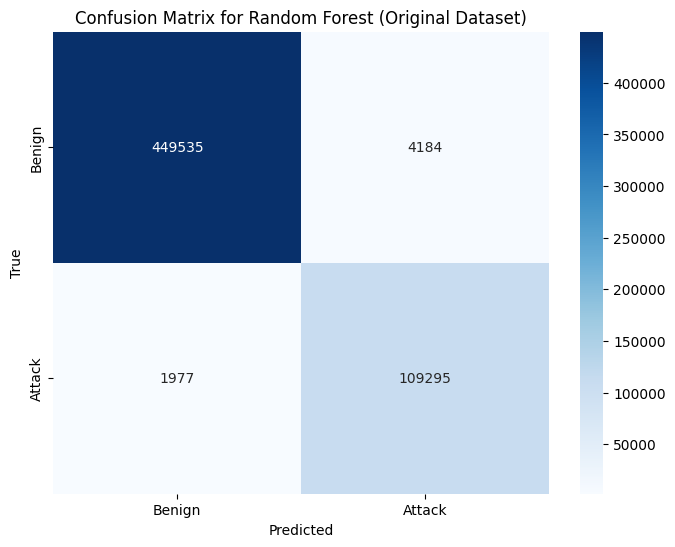

Metrics by Label (Original Dataset):
                         Label  Accuracy
0                       BENIGN  0.990778
1                     DoS Hulk  0.977431
2                     PortScan  0.999843
3                         DDoS  0.998945
4                  FTP-Patator  0.982346
5                DoS GoldenEye  0.992711
6             DoS Slowhttptest  0.993636
7             Web Attack - XSS  0.938462
8                          Bot  0.460358
9     Web Attack - Brute Force  0.880795
10                 SSH-Patator  0.497880
11               DoS slowloris  0.995686
12                Infiltration  0.714286
13  Web Attack - Sql Injection  0.250000
14                  Heartbleed  1.000000


In [103]:
# Predict and evaluate on the test set
rf_metrics["original"] = test_metrics("Random Forest", rf_model, "Original Dataset", scaler)

#### With random oversampler

In [26]:
rf_model_random = RandomForestClassifier(verbose=1)
rf_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 10.7min


RandomForestClassifier(verbose=1)

Random Forest with Random Oversampling Test Set Performance


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s


Classification Report (Test Random Forest (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9969    0.9690    0.9828    453719
           1     0.8867    0.9879    0.9346    111272

    accuracy                         0.9728    564991
   macro avg     0.9418    0.9785    0.9587    564991
weighted avg     0.9752    0.9728    0.9733    564991

Accuracy: 0.9727588581057044
Precision: 0.9752366772126339
Recall: 0.9727588581057044
F1 Score: 0.9733008139758089
AUC: 0.9784741164069464


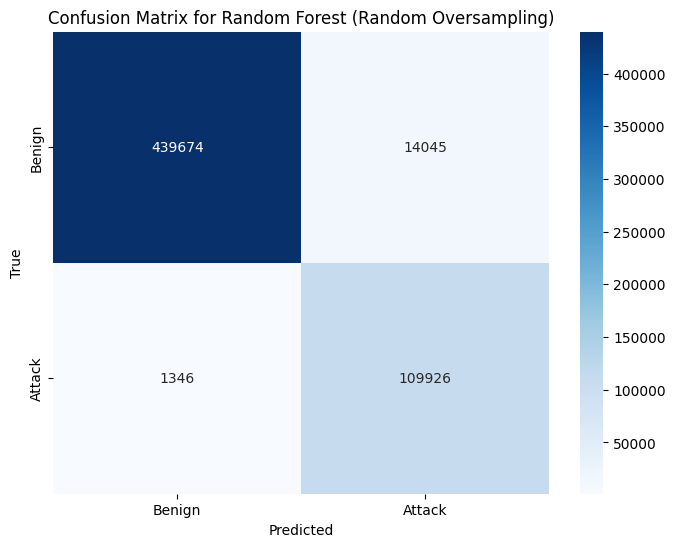

Metrics by Label (Random Oversampling):
                         Label  Accuracy
0                       BENIGN  0.969045
1                     DoS Hulk  0.977410
2                     PortScan  0.999874
3                         DDoS  0.998867
4                  FTP-Patator  0.998739
5                DoS GoldenEye  0.995627
6             DoS Slowhttptest  0.996364
7             Web Attack - XSS  0.946154
8                          Bot  0.772379
9     Web Attack - Brute Force  0.940397
10                 SSH-Patator  0.882952
11               DoS slowloris  0.995686
12                Infiltration  0.857143
13  Web Attack - Sql Injection  0.750000
14                  Heartbleed  1.000000


In [105]:
# Predict and evaluate on the test set
rf_metrics["random"] = test_metrics("Random Forest", rf_model_random, "Random Oversampling", scaler_random)

#### With SMOTE

In [28]:
rf_model_smote = RandomForestClassifier(verbose=1)
rf_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 22.6min


RandomForestClassifier(verbose=1)

Random Forest with SMOTE Test Set Performance


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


Classification Report (Test Random Forest (SMOTE)):
              precision    recall  f1-score   support

           0     0.9971    0.9655    0.9811    453719
           1     0.8755    0.9887    0.9287    111272

    accuracy                         0.9701    564991
   macro avg     0.9363    0.9771    0.9549    564991
weighted avg     0.9732    0.9701    0.9708    564991

Accuracy: 0.9701021786187745
Precision: 0.9731978828551032
Recall: 0.9701021786187745
F1 Score: 0.9707689583058885
AUC: 0.977132025966472


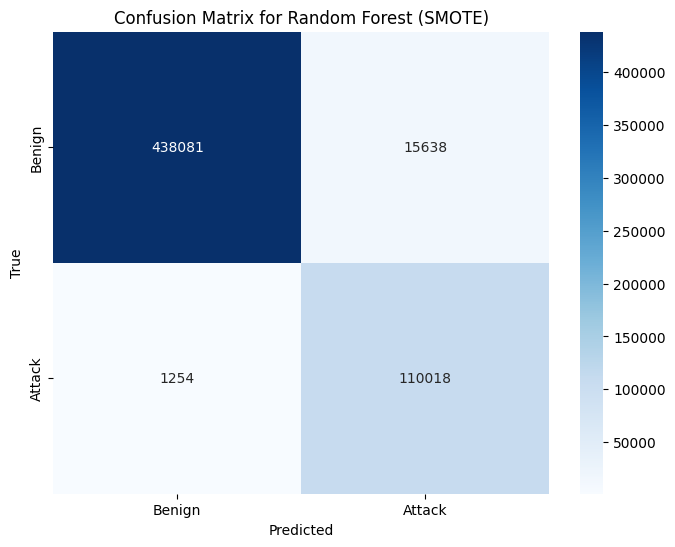

Metrics by Label (SMOTE):
                         Label  Accuracy
0                       BENIGN  0.965534
1                     DoS Hulk  0.978084
2                     PortScan  0.999906
3                         DDoS  0.998945
4                  FTP-Patator  0.998739
5                DoS GoldenEye  0.997085
6             DoS Slowhttptest  0.996364
7             Web Attack - XSS  0.953846
8                          Bot  0.790281
9     Web Attack - Brute Force  0.950331
10                 SSH-Patator  0.918575
11               DoS slowloris  0.996549
12                Infiltration  0.857143
13  Web Attack - Sql Injection  1.000000
14                  Heartbleed  1.000000


In [107]:
# Predict and evaluate on the test set
rf_metrics["smote"] = test_metrics("Random Forest", rf_model_smote, "SMOTE", scaler_smote)

#### With ADASYN

In [30]:
rf_model_adasyn = RandomForestClassifier(verbose=1)
rf_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  7.0min


RandomForestClassifier(verbose=1)

ADASYN Test Set Performance


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


Classification Report (Test (ADASYN)):
              precision    recall  f1-score   support

           0     0.9967    0.9727    0.9845    453719
           1     0.8985    0.9870    0.9407    111272

    accuracy                         0.9755    564991
   macro avg     0.9476    0.9798    0.9626    564991
weighted avg     0.9774    0.9755    0.9759    564991

Accuracy: 0.9754757155423714
Precision: 0.9773814566718095
Recall: 0.9754757155423714
F1 Score: 0.975901352607013
AUC: 0.9798197600743802


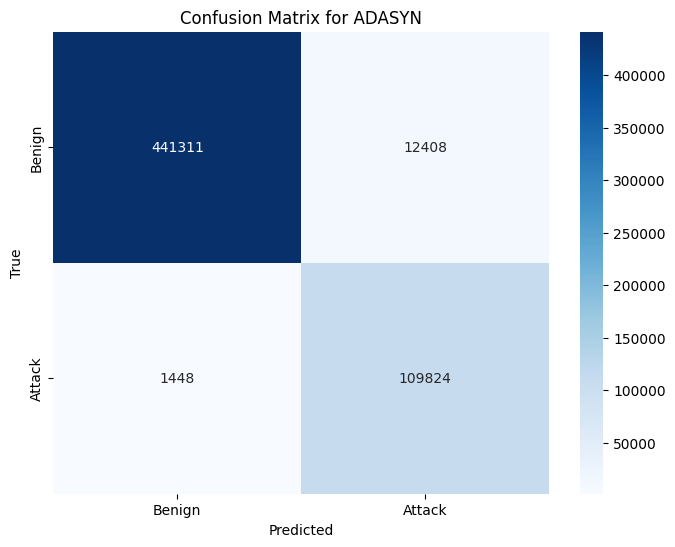

Metrics by Label (ADASYN):
                         Label  Accuracy
0                       BENIGN  0.972653
1                     DoS Hulk  0.978692
2                     PortScan  0.999937
3                         DDoS  0.999023
4                  FTP-Patator  0.984868
5                DoS GoldenEye  0.998542
6             DoS Slowhttptest  0.996364
7             Web Attack - XSS  0.953846
8                          Bot  0.647059
9     Web Attack - Brute Force  0.927152
10                 SSH-Patator  0.798134
11               DoS slowloris  0.996549
12                Infiltration  0.857143
13  Web Attack - Sql Injection  0.750000
14                  Heartbleed  1.000000
Random Forest with ADASYN Test Set Performance


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


Classification Report (Test Random Forest (ADASYN)):
              precision    recall  f1-score   support

           0     0.9967    0.9727    0.9845    453719
           1     0.8985    0.9870    0.9407    111272

    accuracy                         0.9755    564991
   macro avg     0.9476    0.9798    0.9626    564991
weighted avg     0.9774    0.9755    0.9759    564991

Accuracy: 0.9754757155423714
Precision: 0.9773814566718095
Recall: 0.9754757155423714
F1 Score: 0.975901352607013
AUC: 0.9798197600743802


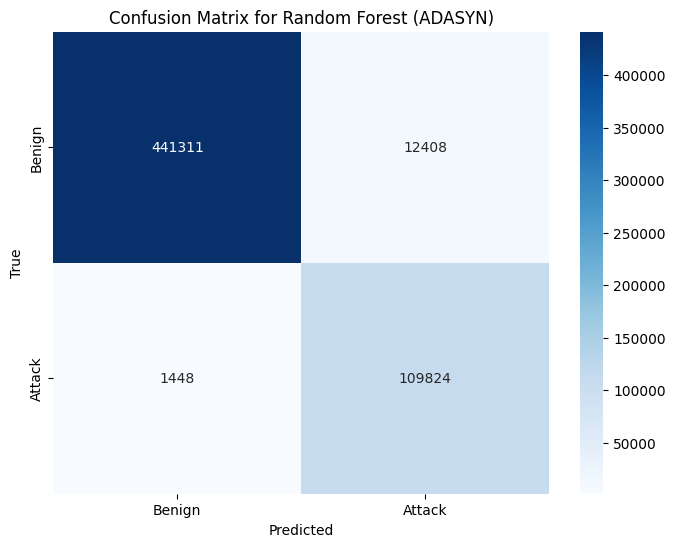

Metrics by Label (ADASYN):
                         Label  Accuracy
0                       BENIGN  0.972653
1                     DoS Hulk  0.978692
2                     PortScan  0.999937
3                         DDoS  0.999023
4                  FTP-Patator  0.984868
5                DoS GoldenEye  0.998542
6             DoS Slowhttptest  0.996364
7             Web Attack - XSS  0.953846
8                          Bot  0.647059
9     Web Attack - Brute Force  0.927152
10                 SSH-Patator  0.798134
11               DoS slowloris  0.996549
12                Infiltration  0.857143
13  Web Attack - Sql Injection  0.750000
14                  Heartbleed  1.000000


In [108]:
# Predict and evaluate on the test set
rf_metrics["adasyn"] = test_metrics("Random Forest", rf_model_adasyn, "ADASYN", scaler_adasyn)

In [110]:
print(rf_metrics)

{'original': ({'accuracy': 0.9727588581057044, 'precision': 0.9752366772126339, 'recall': 0.9727588581057044, 'f1': 0.9733008139758089, 'auc': 0.9784741164069464},                          Label  Accuracy
0                       BENIGN  0.969045
1                     DoS Hulk  0.977410
2                     PortScan  0.999874
3                         DDoS  0.998867
4                  FTP-Patator  0.998739
5                DoS GoldenEye  0.995627
6             DoS Slowhttptest  0.996364
7             Web Attack - XSS  0.946154
8                          Bot  0.772379
9     Web Attack - Brute Force  0.940397
10                 SSH-Patator  0.882952
11               DoS slowloris  0.995686
12                Infiltration  0.857143
13  Web Attack - Sql Injection  0.750000
14                  Heartbleed  1.000000), 'random': ({'accuracy': 0.9727588581057044, 'precision': 0.9752366772126339, 'recall': 0.9727588581057044, 'f1': 0.9733008139758089, 'auc': 0.9784741164069464},                  

In [89]:
metrics_original['Method'] = 'Original'
metrics_random['Method'] = 'Random Oversampling'
metrics_smote['Method'] = 'SMOTE'
metrics_adasyn['Method'] = 'ADASYN'
# Combine metrics into one DataFrame
combined_metrics = pd.concat([metrics_adasyn, metrics_original, metrics_random, metrics_smote])
# Pivot the table to get accuracy for each method as columns in the specified order
accuracy_pivot = combined_metrics.pivot(index='Label', columns='Method', values='Accuracy')
accuracy_pivot = accuracy_pivot[['Original', 'Random Oversampling', 'SMOTE', 'ADASYN']]
print("Accuracy by Label and Method:")
print(accuracy_pivot)

Accuracy by Label and Method:
Method                      Original  Random Oversampling     SMOTE    ADASYN
Label                                                                        
BENIGN                      0.990778             0.969045  0.965534  0.972653
Bot                         0.460358             0.772379  0.790281  0.647059
DDoS                        0.998945             0.998867  0.998945  0.999023
DoS GoldenEye               0.992711             0.995627  0.997085  0.998542
DoS Hulk                    0.977431             0.977410  0.978084  0.978692
DoS Slowhttptest            0.993636             0.996364  0.996364  0.996364
DoS slowloris               0.995686             0.995686  0.996549  0.996549
FTP-Patator                 0.982346             0.998739  0.998739  0.984868
Heartbleed                  1.000000             1.000000  1.000000  1.000000
Infiltration                0.714286             0.857143  0.857143  0.857143
PortScan                    0.9998

### Gradient Boost (XGB)

In [34]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()
xgb_model.fit(scaler.transform(X_train), Y_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Original Dataset Test Set Performance
Classification Report (Test (Original)):
              precision    recall  f1-score   support

           0     0.9956    0.9907    0.9931    453719
           1     0.9627    0.9820    0.9722    111272

    accuracy                         0.9889    564991
   macro avg     0.9791    0.9863    0.9827    564991
weighted avg     0.9891    0.9889    0.9890    564991

Accuracy: 0.9889484965247234
Precision: 0.9890786049494759
Recall: 0.9889484965247234
F1 Score: 0.9889897779963487
AUC: 0.9863191521621291


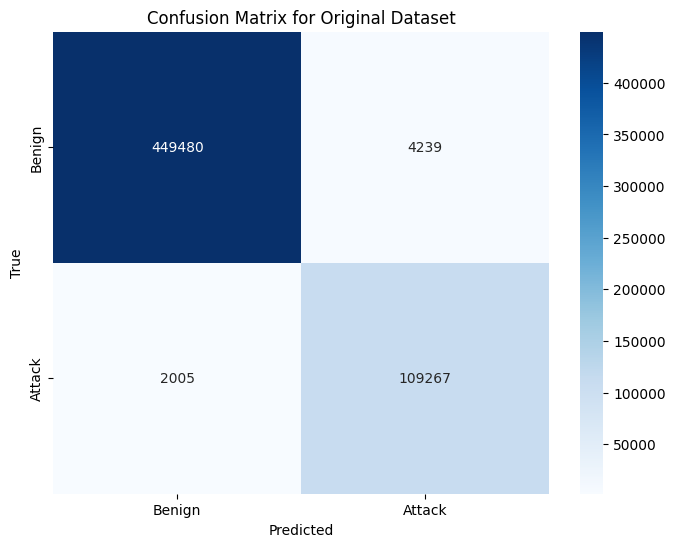

In [35]:
# Predict and evaluate on the test set
print("Original Dataset Test Set Performance")
Y_pred = xgb_model.predict(scaler.transform(X_test))
metrics_report("Test (Original)", Y_test.is_attack, Y_pred)
plot_confusion_matrix("Original Dataset", Y_test, Y_pred)

In [37]:
xgb_model_random = xgb.XGBClassifier()
xgb_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Random Oversampling Test Set Performance
Classification Report (Test (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9970    0.9685    0.9826    453719
           1     0.8851    0.9881    0.9338    111272

    accuracy                         0.9724    564991
   macro avg     0.9410    0.9783    0.9582    564991
weighted avg     0.9750    0.9724    0.9730    564991

Accuracy: 0.9723942505278845
Precision: 0.9749605642846713
Recall: 0.9723942505278845
F1 Score: 0.9729536482270774
AUC: 0.9783318908963177


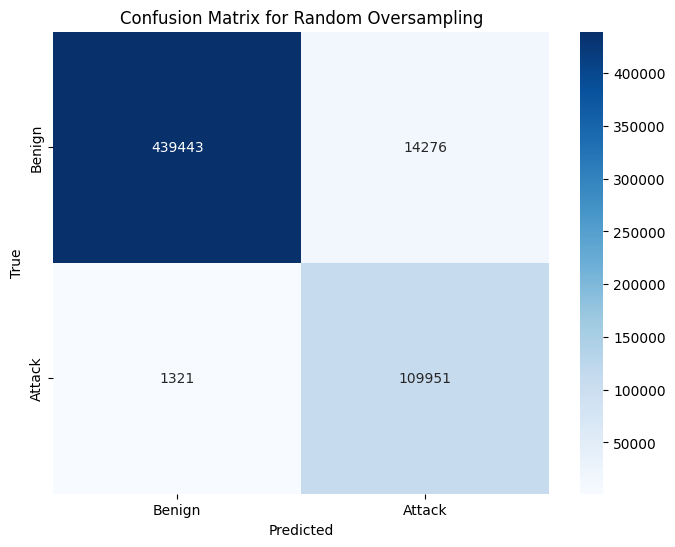

In [38]:
# Predict and evaluate on the test set
print("Random Oversampling Test Set Performance")
Y_random_pred = xgb_model_random.predict(scaler_random.transform(X_test))
metrics_report("Test (Random Oversampling)", Y_test.is_attack, Y_random_pred)
plot_confusion_matrix("Random Oversampling", Y_test, Y_random_pred)

In [39]:
xgb_model_smote = xgb.XGBClassifier()
xgb_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

SMOTE Test Set Performance
Classification Report (Test (SMOTE)):
              precision    recall  f1-score   support

           0     0.9972    0.9693    0.9830    453719
           1     0.8876    0.9888    0.9354    111272

    accuracy                         0.9731    564991
   macro avg     0.9424    0.9790    0.9592    564991
weighted avg     0.9756    0.9731    0.9737    564991

Accuracy: 0.9731234656835241
Precision: 0.9755849638947556
Recall: 0.9731234656835241
F1 Score: 0.9736577796609329
AUC: 0.9790334951578662


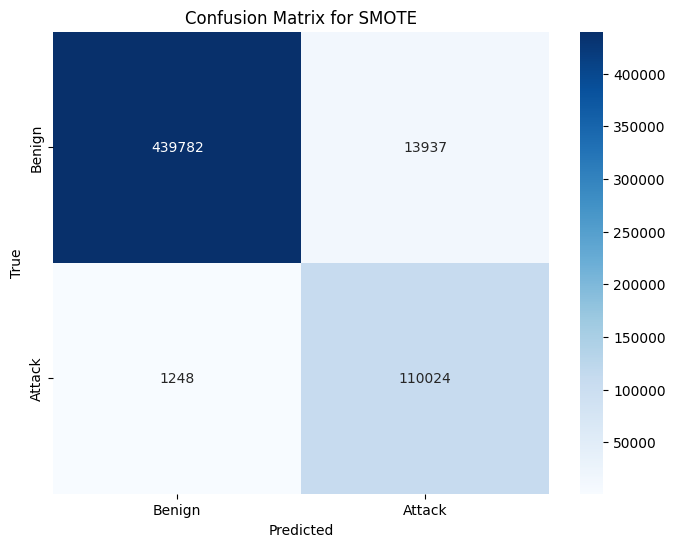

In [40]:
# Predict and evaluate on the test set
print("SMOTE Test Set Performance")
Y_smote_pred = xgb_model_smote.predict(scaler_smote.transform(X_test))
metrics_report("Test (SMOTE)", Y_test.is_attack, Y_smote_pred)
plot_confusion_matrix("SMOTE", Y_test, Y_smote_pred)

In [41]:
xgb_model_adasyn = xgb.XGBClassifier()
xgb_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

ADASYN Test Set Performance
Classification Report (Test (ADASYN)):
              precision    recall  f1-score   support

           0     0.9962    0.9775    0.9868    453719
           1     0.9148    0.9850    0.9486    111272

    accuracy                         0.9790    564991
   macro avg     0.9555    0.9812    0.9677    564991
weighted avg     0.9802    0.9790    0.9793    564991

Accuracy: 0.978976656265321
Precision: 0.98020708560695
Recall: 0.978976656265321
F1 Score: 0.9792651339463139
AUC: 0.9812432211037756


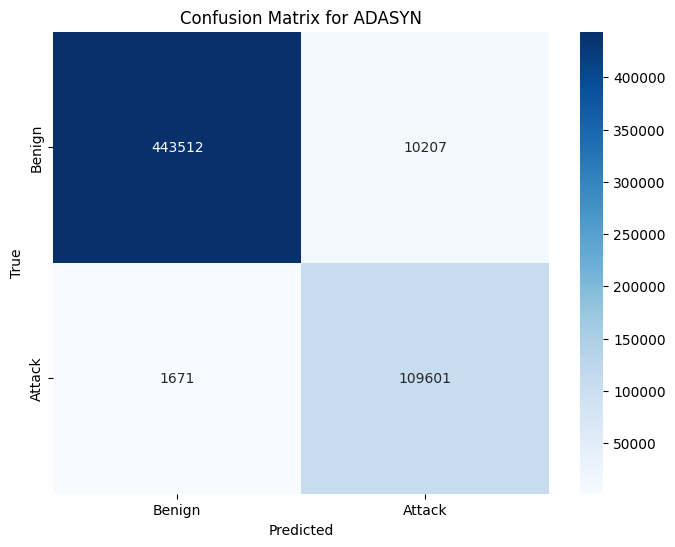

In [42]:
# Predict and evaluate on the test set
print("ADASYN Test Set Performance")
Y_adasyn_pred = xgb_model_adasyn.predict(scaler_adasyn.transform(X_test))
metrics_report("Test (ADASYN)", Y_test.is_attack, Y_adasyn_pred)
plot_confusion_matrix("ADASYN", Y_test, Y_adasyn_pred)

### AdaBoost

In [43]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()
ada_model.fit(scaler.transform(X_train), Y_train.is_attack)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

Original Dataset Test Set Performance
Classification Report (Test (Original)):
              precision    recall  f1-score   support

           0     0.9672    0.9925    0.9797    453719
           1     0.9658    0.8626    0.9113    111272

    accuracy                         0.9669    564991
   macro avg     0.9665    0.9276    0.9455    564991
weighted avg     0.9669    0.9669    0.9662    564991

Accuracy: 0.9669322166193798
Precision: 0.9669042635904159
Recall: 0.9669322166193798
F1 Score: 0.9662126330244671
AUC: 0.9275621701356269


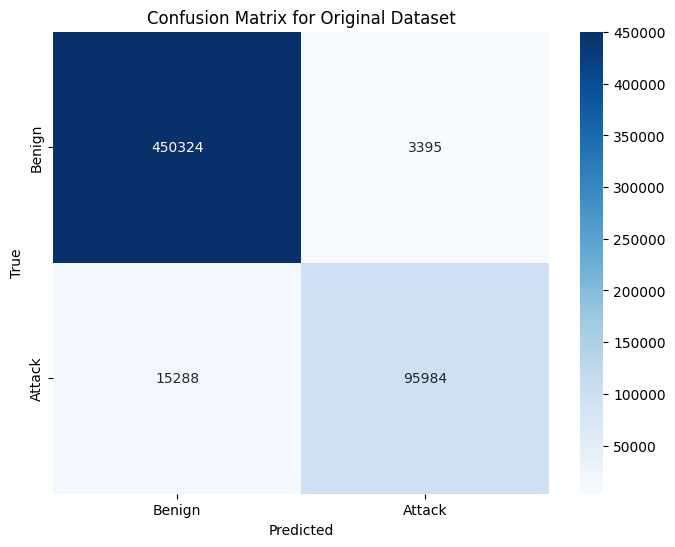

In [44]:
# Predict and evaluate on the test set
print("Original Dataset Test Set Performance")
Y_pred = ada_model.predict(scaler.transform(X_test))
metrics_report("Test (Original)", Y_test.is_attack, Y_pred)
plot_confusion_matrix("Original Dataset", Y_test, Y_pred)

In [45]:
ada_model_random = AdaBoostClassifier()
ada_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

Random Oversampling Test Set Performance
Classification Report (Test (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9783    0.9081    0.9419    453719
           1     0.7100    0.9179    0.8007    111272

    accuracy                         0.9100    564991
   macro avg     0.8442    0.9130    0.8713    564991
weighted avg     0.9255    0.9100    0.9141    564991

Accuracy: 0.9099985663488445
Precision: 0.9254734104971639
Recall: 0.9099985663488445
F1 Score: 0.9140700367388663
AUC: 0.9129920292590835


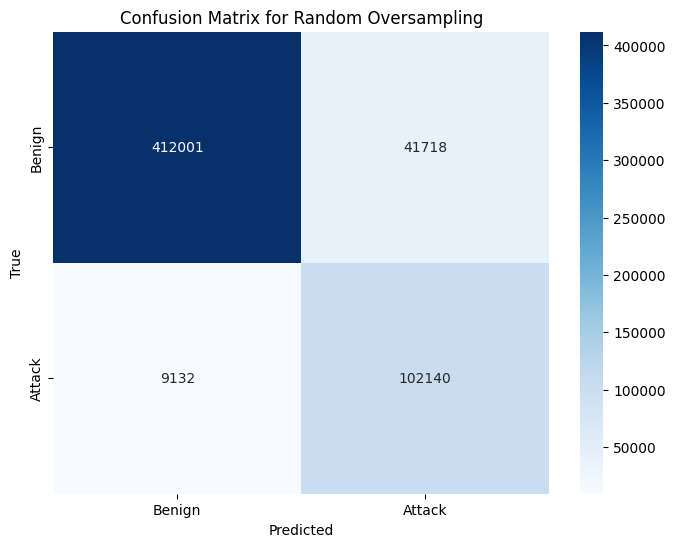

In [46]:
# Predict and evaluate on the test set
print("Random Oversampling Test Set Performance")
Y_random_pred = ada_model_random.predict(scaler_random.transform(X_test))
metrics_report("Test (Random Oversampling)", Y_test.is_attack, Y_random_pred)
plot_confusion_matrix("Random Oversampling", Y_test, Y_random_pred)

In [47]:
ada_model_smote = AdaBoostClassifier()
ada_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

SMOTE Test Set Performance
Classification Report (Test (SMOTE)):
              precision    recall  f1-score   support

           0     0.9644    0.8988    0.9304    453719
           1     0.6768    0.8645    0.7593    111272

    accuracy                         0.8920    564991
   macro avg     0.8206    0.8817    0.8448    564991
weighted avg     0.9077    0.8920    0.8967    564991

Accuracy: 0.8920212888346895
Precision: 0.9077268190303045
Recall: 0.8920212888346895
F1 Score: 0.8966956344332065
AUC: 0.881650137398338


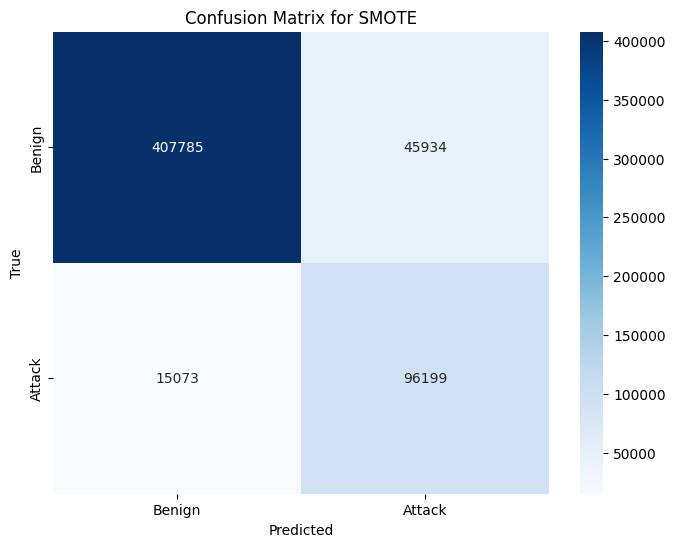

In [48]:
# Predict and evaluate on the test set
print("SMOTE Test Set Performance")
Y_smote_pred = ada_model_smote.predict(scaler_smote.transform(X_test))
metrics_report("Test (SMOTE)", Y_test.is_attack, Y_smote_pred)
plot_confusion_matrix("SMOTE", Y_test, Y_smote_pred)

In [49]:
ada_model_adasyn = AdaBoostClassifier()
ada_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

ADASYN Test Set Performance
Classification Report (Test (ADASYN)):
              precision    recall  f1-score   support

           0     0.9651    0.8812    0.9212    453719
           1     0.6424    0.8699    0.7390    111272

    accuracy                         0.8790    564991
   macro avg     0.8037    0.8756    0.8301    564991
weighted avg     0.9015    0.8790    0.8854    564991

Accuracy: 0.8789998424753669
Precision: 0.9015077169672359
Recall: 0.8789998424753669
F1 Score: 0.8853550430185089
AUC: 0.8755640243452497


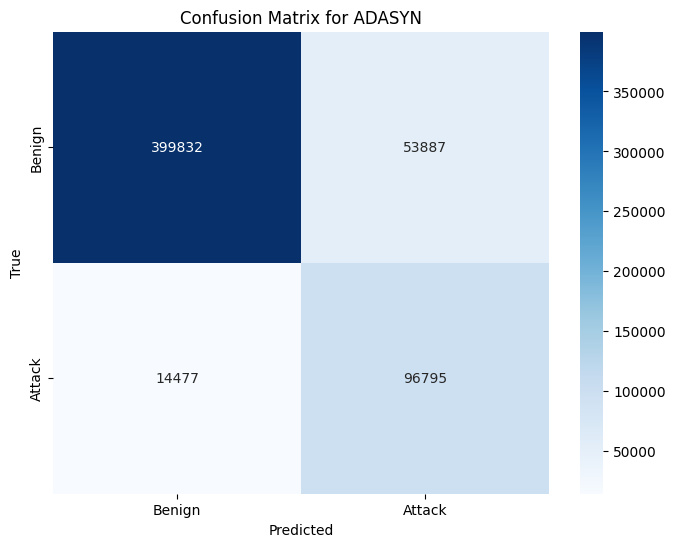

In [50]:
# Predict and evaluate on the test set
print("ADASYN Test Set Performance")
Y_adasyn_pred = ada_model_adasyn.predict(scaler_adasyn.transform(X_test))
metrics_report("Test (ADASYN)", Y_test.is_attack, Y_adasyn_pred)
plot_confusion_matrix("ADASYN", Y_test, Y_adasyn_pred)

### Decision Tree

In [51]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier()

Original Dataset Test Set Performance
Classification Report (Test (Original)):
              precision    recall  f1-score   support

           0     0.9955    0.9907    0.9931    453719
           1     0.9627    0.9816    0.9720    111272

    accuracy                         0.9889    564991
   macro avg     0.9791    0.9861    0.9825    564991
weighted avg     0.9890    0.9889    0.9889    564991

Accuracy: 0.9888776989367972
Precision: 0.9890048737347821
Recall: 0.9888776989367972
F1 Score: 0.9889184378532939
AUC: 0.9861326294457511


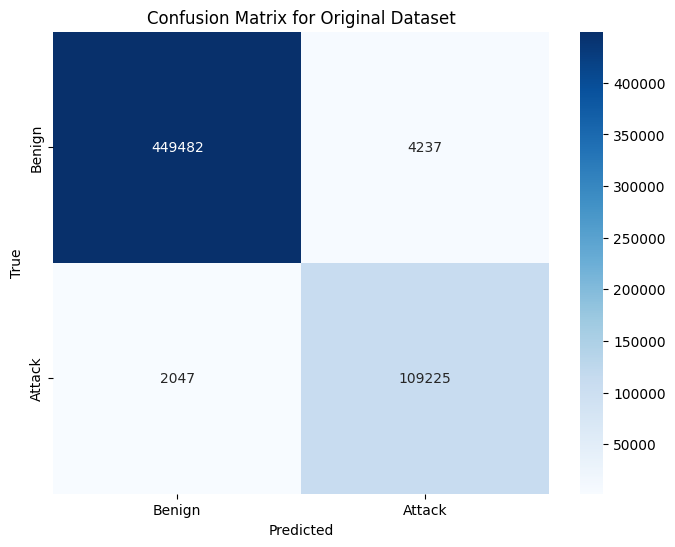

In [52]:
# Predict and evaluate on the test set
print("Original Dataset Test Set Performance")
Y_pred = decision_tree_model.predict(scaler.transform(X_test))
metrics_report("Test (Original)", Y_test.is_attack, Y_pred)
plot_confusion_matrix("Original Dataset", Y_test, Y_pred)

In [53]:
decision_tree_model_random = DecisionTreeClassifier()
decision_tree_model_random.fit(scaler_random.transform(X_random_train), Y_random_train.is_attack)

DecisionTreeClassifier()

Random Oversampling Test Set Performance
Classification Report (Test (Random Oversampling)):
              precision    recall  f1-score   support

           0     0.9966    0.9698    0.9830    453719
           1     0.8890    0.9864    0.9352    111272

    accuracy                         0.9731    564991
   macro avg     0.9428    0.9781    0.9591    564991
weighted avg     0.9754    0.9731    0.9736    564991

Accuracy: 0.9730685975528813
Precision: 0.9753893276206984
Recall: 0.9730685975528813
F1 Score: 0.9735845329775564
AUC: 0.9781005882583181


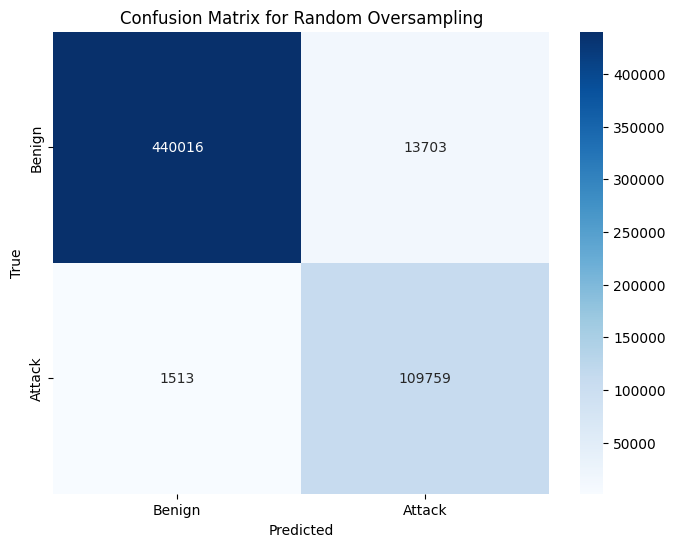

In [54]:
# Predict and evaluate on the test set
print("Random Oversampling Test Set Performance")
Y_random_pred = decision_tree_model_random.predict(scaler_random.transform(X_test))
metrics_report("Test (Random Oversampling)", Y_test.is_attack, Y_random_pred)
plot_confusion_matrix("Random Oversampling", Y_test, Y_random_pred)

In [55]:
decision_tree_model_smote = DecisionTreeClassifier()
decision_tree_model_smote.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

DecisionTreeClassifier()

SMOTE Test Set Performance
Classification Report (Test (SMOTE)):
              precision    recall  f1-score   support

           0     0.9967    0.9722    0.9843    453719
           1     0.8970    0.9868    0.9397    111272

    accuracy                         0.9751    564991
   macro avg     0.9468    0.9795    0.9620    564991
weighted avg     0.9770    0.9751    0.9755    564991

Accuracy: 0.9750774791102867
Precision: 0.9770418517859543
Recall: 0.9750774791102867
F1 Score: 0.9755164591977641
AUC: 0.9794870220062301


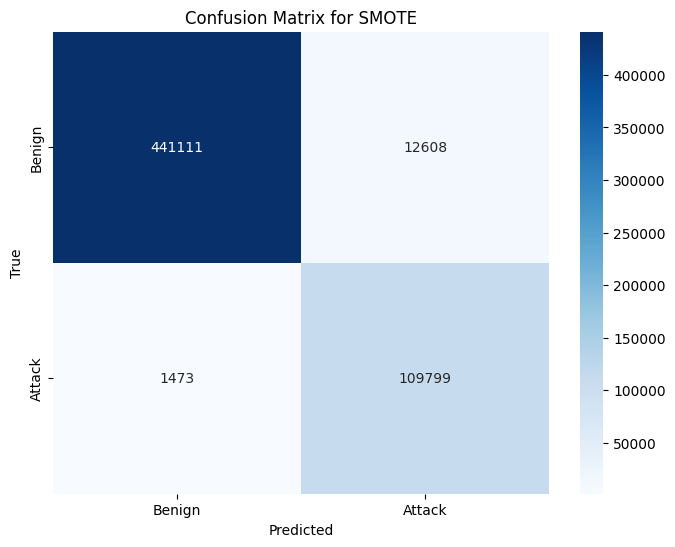

In [56]:
# Predict and evaluate on the test set
print("SMOTE Test Set Performance")
Y_smote_pred = decision_tree_model_smote.predict(scaler_smote.transform(X_test))
metrics_report("Test (SMOTE)", Y_test.is_attack, Y_smote_pred)
plot_confusion_matrix("SMOTE", Y_test, Y_smote_pred)

In [57]:
decision_tree_model_adasyn = DecisionTreeClassifier()
decision_tree_model_adasyn.fit(scaler_adasyn.transform(X_adasyn_train), Y_adasyn_train.is_attack)

DecisionTreeClassifier()

ADASYN Test Set Performance
Classification Report (Test (ADASYN)):
              precision    recall  f1-score   support

           0     0.9956    0.9876    0.9916    453719
           1     0.9510    0.9821    0.9663    111272

    accuracy                         0.9865    564991
   macro avg     0.9733    0.9848    0.9789    564991
weighted avg     0.9868    0.9865    0.9866    564991

Accuracy: 0.9864953601030813
Precision: 0.9867827312078633
Recall: 0.9864953601030813
F1 Score: 0.9865768311899863
AUC: 0.9848256899827124


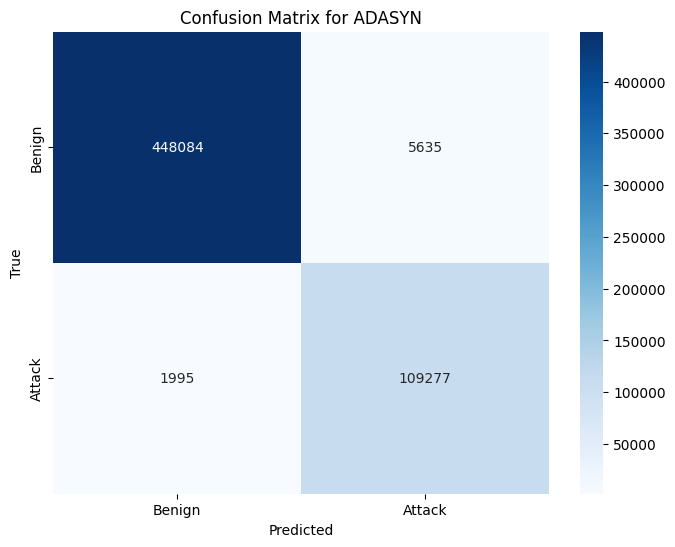

In [58]:
# Predict and evaluate on the test set
print("ADASYN Test Set Performance")
Y_adasyn_pred = decision_tree_model_adasyn.predict(scaler_adasyn.transform(X_test))
metrics_report("Test (ADASYN)", Y_test.is_attack, Y_adasyn_pred)
plot_confusion_matrix("ADASYN", Y_test, Y_adasyn_pred)

## 5. Machine Learning with Hyperparameter Optimization